In [3]:
import torch
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import numpy as np
from sklearn.metrics import classification_report
from transformers import TOKENIZER_MAPPING, AutoModelForSequenceClassification, AutoTokenizer, AdamW, get_linear_schedule_with_warmup, XLMRobertaTokenizer, XLMRobertaForSequenceClassification
import os
from dataset import Dataset
import pandas as pd

In [2]:
TOKENIZER_NAME = "sentence-transformers/paraphrase-xlm-r-multilingual-v1"
MODEL_NAME = "sentence-transformers/paraphrase-xlm-r-multilingual-v1"
LEARNING_RATE = 3e-5

#OUTPUT_FILE = "NODUP-paraphrase-roberta-kan-pickle.md"

EPOCHS = 4
BATCH_SIZE = 24 
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())    
    print(f'We will use the GPU:{torch.cuda.get_device_name()} ({device})')

else:
    print('NO GPU AVAILABLE ERROR')
    device = torch.device("cpu")
   
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
model = AutoModelForSequenceClassification.from_pretrained("../../task_a/pickles_mal/", num_labels=5, output_attentions=True)

model.to(device)
optimizer = AdamW(model.parameters(), lr = LEARNING_RATE, no_deprecation_warning=True)

data = Dataset()
_, _, _, _, datatrain, _, _, _ = data.get_phobia_dataset(tokenizer, balance=False)
#_,_, kan_train_2022, _, _,_ = data.get_fire_2022_dataset(tokenizer, balance=False)

train_dataloader = DataLoader(
            datatrain,
            sampler = RandomSampler(datatrain),
            batch_size = BATCH_SIZE)

total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)


There are 2 GPU(s) available.
We will use the GPU:Tesla V100-SXM2-32GB (cuda)
Texts: 3128
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 790
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 1750
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 621
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 2521
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 837
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 3807
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 962
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')


In [34]:
def correlation_validation(model, tokenizer, device, output_file, dataset, BS=16):
    _, eng_val, _, tam_val, _, mal_val, _, eng_tam_val = data.get_phobia_dataset(tokenizer, balance=False)

    if dataset == 'tam':
        loader = DataLoader(tam_val, sampler = SequentialSampler(tam_val), batch_size=BS)
    elif dataset == 'eng':
        loader = DataLoader(eng_val, sampler = SequentialSampler(eng_val), batch_size=BS) 
    elif dataset == 'mal':
        loader = DataLoader(mal_val, sampler = SequentialSampler(mal_val), batch_size=BS) 
    elif dataset == 'eng_tam':
        loader = DataLoader(eng_tam_val, sampler = SequentialSampler(eng_tam_val), batch_size=BS) 

    print(f"{dataset} validation: {len(loader) * BS}")
    
    vbar = tqdm(enumerate(loader), total=len(loader), desc= dataset + " validation")

    model.eval()
    
    true_labels = []
    pred_labels = []
    
    # Label names: Index(['Mixed_feelings', 'Negative', 'Positive', 'not-Tamil', 'unknown_state']
    # Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic']
    datalist = []
    for step, batch in vbar:
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad(): 
            outputs = model(input_ids=b_input_ids, attention_mask=b_masks,
                                            labels=b_labels)
            
            logits = outputs.logits.detach().cpu().numpy().tolist()
            label_ids = b_labels.to('cpu').numpy().tolist()
            
            true_labels.extend(label_ids)
            
            for i in range(len(logits)):
                datalist.append([label_ids[i]i, logits[i][0], logits[i][1], logits[i][2], logits[i][3], logits[i][4]])
            
            #print(f"Predicted: {pred_labels[-1]}, {np.argmax(i)}")
            #print(f"{pred_labels[-24:]},{np.argmax(logits_two, axis=1)}")
            #pred_labels.extend(np.argmax(logits,axis=1))
        
        #f = open("../outputs/sentiment", 'a')
        #f.write(str(pred_labels))
    #print(classification_report(pred_labels, true_labels))
    model.train()
    return datalist

In [35]:
d = correlation_validation(model, tokenizer, device, "whatever", 'mal')

Texts: 3128
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 790
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 1750
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 621
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 2521
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 837
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 3807
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')
Texts: 962
Label names: Index(['Homophobic', 'Non-anti-LGBT+ content', 'Transphobic'], dtype='object')


mal validation:   2%|▏         | 1/53 [00:00<00:08,  6.46it/s]

mal validation: 848


mal validation: 100%|██████████| 53/53 [00:08<00:00,  6.54it/s]


In [64]:
newpd = pd.DataFrame(d)
newpd

,0,1,2,3,4,5
0,1,0.560379,-1.718061,4.669591,-1.898087,-2.396322
1,1,0.242928,4.715206,-1.996880,-1.318356,-0.944085
2,2,-1.799854,-1.412141,-0.487429,-1.672019,5.212455
3,1,-0.010422,-0.367036,2.181917,-3.973779,1.868147
4,1,0.387174,-0.122948,-1.515658,-2.248460,3.613434
...,...,...,...,...,...,...
832,0,0.219181,4.679481,-2.362907,-1.389163,-0.515743
833,1,0.914604,3.422101,-3.043780,-2.481498,1.681538
834,1,-0.669411,0.314440,1.914513,-4.194406,2.002320
835,1,1.294632,1.738855,-2.429878,-2.345985,1.957118


Text(0.5, 0.98, 'Hi')

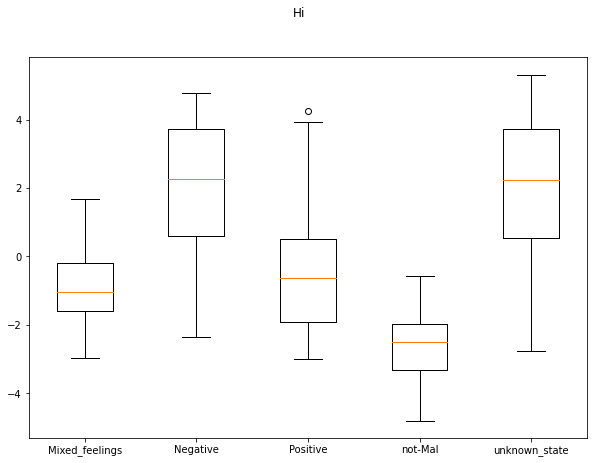

In [74]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
plt.boxplot(newpd[newpd[0] == 0][[1,2,3,4,5]])
ax.set_xticklabels(['Mixed_feelings', 'Negative', 'Positive', 'not-Mal', 'unknown_state'])
fig.suptitle('Hi')

,1,2,3,4,5
7,-2.304896,2.875112,-1.225662,-1.825821,2.681648
11,0.062972,1.135151,0.534536,-4.205377,2.227875
23,0.502136,3.995558,-1.888023,-0.761091,-0.992518
29,-1.257297,1.514892,-2.932900,-0.863507,3.908458
30,-0.122110,3.191111,1.254580,-2.787676,-1.425577
...,...,...,...,...,...
795,-1.557761,2.602370,-1.709796,-2.382521,3.270941
812,-1.834744,-0.840837,2.394250,-2.207379,2.229791
814,-1.035318,3.802910,-1.753866,-2.743971,2.125322
828,1.161907,3.134627,1.034112,-2.494465,-2.768089
